# Import libraries

In [77]:
import os
import sys
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()

In [78]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Load Sumstats

In [79]:
disease = "ms"
scenario = "abyss"
max_maf = 0.5
min_maf = 0
logp_min = 6
logp_max = 100
P_cutoff = 5e-8
PCs = 15
nr_snps = 300
bin =17

In [80]:
path_input = glob.PATH_GENO + f"/09_summary_statistics/{disease}/{scenario}"

In [81]:
list_of_bins = os.listdir(path_input)

In [82]:
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

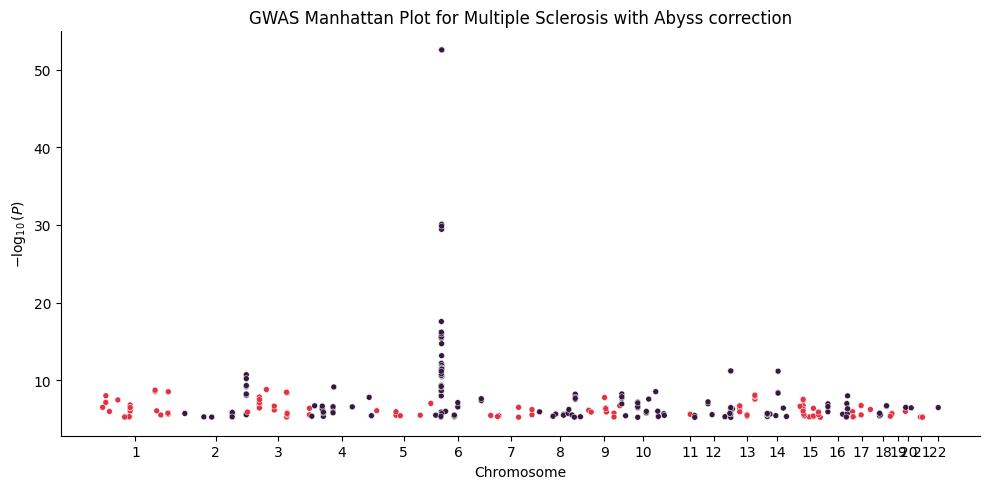

In [83]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Find geno and mafs for selected SNPs

In [84]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,cumulative_pos,SNP number,color
5378,1:93192264:C_T_T,0.390125,-0.031438,0.146476,0.010084,-3.117756,0.001844,1,93192264,6.295681,17,93192264,5378,"(0.20973515, 0.09747934, 0.24238489)"
6075,1:206915809:A_G_A,1.524786,0.030396,-1.355554,0.010412,2.919212,0.003542,1,206915809,5.642969,17,206915809,6075,"(0.20973515, 0.09747934, 0.24238489)"
32093,1:167562370:A_T_A,0.875287,-0.037432,-0.501725,0.009982,-3.749896,0.000181,1,167562370,8.616162,17,167562370,32093,"(0.20973515, 0.09747934, 0.24238489)"
6663,1:167563012:C_T_T,0.866353,-0.037413,-0.485912,0.009985,-3.746814,0.000183,1,167563012,8.603950,17,167563012,6663,"(0.20973515, 0.09747934, 0.24238489)"
25101,1:184541602:A_G_G,-0.032736,-0.030418,0.717211,0.010536,-2.886980,0.003925,1,184541602,5.540418,17,184541602,25101,"(0.20973515, 0.09747934, 0.24238489)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12889,20:17315191:C_T_C,-0.262528,0.032406,1.037475,0.010238,3.165365,0.001569,20,17315191,6.457581,17,2425523294,12889,"(0.8833417, 0.19830556, 0.26014181)"
4714,21:27465597:C_T_T,-0.231318,-0.028709,0.964544,0.010249,-2.801065,0.005135,21,27465597,5.271707,17,2452988891,4714,"(0.20973515, 0.09747934, 0.24238489)"
8294,21:33419671:A_G_G,1.631091,0.028919,-1.527037,0.010286,2.811624,0.004970,21,33419671,5.304366,17,2458942965,8294,"(0.20973515, 0.09747934, 0.24238489)"
29735,21:33410073:C_T_C,1.007261,0.028809,-0.687344,0.010315,2.792932,0.005265,21,33410073,5.246616,17,2458933367,29735,"(0.20973515, 0.09747934, 0.24238489)"


In [85]:
unique_bins = list(sumstat['bin'].unique())

In [86]:
genos = []
mafs = []

# Iterate over unique bins
for unique_bin in unique_bins:
    # Filter sumstat for the current bin
    temp_sumstat = sumstat[sumstat['bin'] == unique_bin]

    # Construct path for genotype mapping
    path_geno_mapping = os.path.join(glob.PATH_GENO, f"04_LD_blocks/{PCs}_PCs/bin_{unique_bin}")
    
    # Load mapping data
    map_file = os.path.join(path_geno_mapping, "mapping.pkl")
    map = pd.read_pickle(map_file)
    map.rename(columns={'Position': 'POS'}, inplace=True)
    map['POS'] = map['POS'].astype(int)

    # Get path for MAF dimensions
    path_dims_of_maf = os.path.join(glob.PATH_GENO, f"08_MAF_probability_landscape/{disease}/bin_{unique_bin}")
    dims_of_maf = os.listdir(path_dims_of_maf)[0]
    path_maf = os.path.join(path_dims_of_maf, dims_of_maf)

    # Merge sumstat with mapping data
    temp_sumstat = pd.merge(temp_sumstat, map[['POS','Chromosome','Alls2', 'path']], on='POS', how='inner')
    
    # Process each unique path
    unique_paths = temp_sumstat['path'].unique()
    for path in unique_paths:
        temp2_sumstat = temp_sumstat[temp_sumstat['path'] == path]
        SNPS = temp2_sumstat['snp'].tolist()
        
        # Find the file with SNP data and load genotypes
        file_with_snp = next(f for f in os.listdir(path_geno_mapping) if f.startswith(path))
        path_file_genos = os.path.join(path_geno_mapping, file_with_snp)
        geno = pd.read_pickle(path_file_genos)[SNPS]
        genos.append(geno)

        # Load MAF data
        path_file_maf = os.path.join(path_maf, file_with_snp)
        maf = pd.read_pickle(path_file_maf)[SNPS]
        mafs.append(maf)

In [87]:
combined_geno = pd.concat(genos, axis=1)

In [88]:
combined_maf = pd.concat(mafs, axis=1)

In [89]:
combined_geno

,1:93192264:C_T_T,1:11002488:C_T_T,3:121806825:C_T_T,14:69180411:G_T_G,1:206915809:A_G_A,3:39168283:C_T_C,16:22730776:A_G_A,17:16791658:A_G_A,1:167562370:A_T_A,6:32165583:A_G_G,...,19:11270867:C_T_T,15:40604862:G_T_G,15:51451185:A_C_C,22:47262388:A_G_G,15:95689069:A_G_A,16:79219583:A_G_A,16:81368904:C_T_C,16:77871108:C_T_C,18:48182328:A_G_A,20:17315191:C_T_C
0,1,0,0,0,1,1,1,0,0,0,...,1,0,0,0,1,1,0,1,0,1
1,1,0,1,1,1,1,0,1,1,1,...,1,1,1,0,1,1,0,-1,1,1
2,1,-1,1,1,0,0,1,0,0,1,...,1,0,1,1,1,0,1,0,1,1
3,0,-1,1,1,0,0,1,1,1,1,...,-1,1,1,-1,0,1,1,0,1,1
4,0,1,1,1,1,1,1,0,0,0,...,-1,1,1,0,1,1,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69450,0,1,0,0,1,1,1,1,0,-1,...,1,0,1,-1,1,1,0,0,-1,1
69451,-1,0,-1,0,-1,1,0,0,1,1,...,0,1,1,1,1,0,0,1,0,1
69452,1,-1,-1,1,1,1,-1,0,0,0,...,0,1,-1,0,1,0,1,0,1,1
69453,0,1,1,0,1,0,0,1,0,1,...,-1,0,1,1,1,1,0,0,1,1


In [103]:
# Extract chromosome numbers and group columns
chromosome_to_columns = {}
for col in combined_geno.columns:
    chromosome = col.split(':')[0]
    if chromosome not in chromosome_to_columns:
        chromosome_to_columns[chromosome] = []
    chromosome_to_columns[chromosome].append(col)

# Split into separate DataFrames based on chromosome
chromosome_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_dfs[chromosome] = combined_geno[cols]

In [110]:
# Split into separate DataFrames based on chromosome
chromosome_maf_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_maf_dfs[chromosome] = combined_maf[cols]

# Order in LD blocks

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from k_means_constrained import KMeansConstrained
from abyss.glob import glob
import random
from math import floor
from collections import Counter

In [91]:

genos = combined_geno.T
features = genos.columns

In [92]:
n_components = 15
num_clus = 3

In [93]:
sample_size = np.round(nr_snps//num_clus)
size_min = sample_size - round(sample_size / 5)
size_max = sample_size + round(sample_size / 5)

In [94]:
# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(genos)

# Perform PCA with n components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df_scaled)

# Create a new DataFrame to store the principal components
pc_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)

# Apply constrained K-Means clustering
clf = KMeansConstrained(
    n_clusters=num_clus,
    size_min=size_min,
    size_max=size_max,
    random_state=0
)
clf.fit_predict(np.array(df_pca))

# Assign cluster labels to genotypic data
count = Counter(clf.labels_)

In [95]:
df_pca['labels'] = clf.labels_

In [96]:
df_pca

,PC1,PC2,labels
0,-26.392384,-15.999090,3
1,-5.185349,-2.647950,1
2,-6.709424,-2.056562,7
3,-8.031989,-1.254176,7
4,-7.268376,0.573747,7
...,...,...,...
295,-9.417397,-4.372053,5
296,-10.183080,-2.093055,6
297,-8.724484,-1.679849,0
298,-10.407128,-0.673075,8


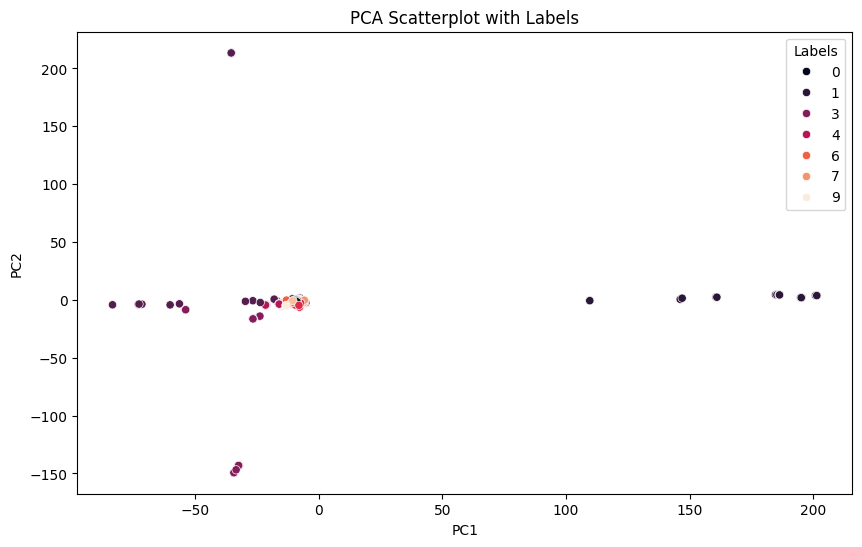

In [97]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='PC1', y='PC2', hue='labels', palette='rocket', data=df_pca)



# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')

plt.legend(title='Labels')

plt.show()

In [98]:
pd.DataFrame(data = {"snp": list(genos.index)})

,snp
0,1:93192264:C_T_T
1,1:11002488:C_T_T
2,3:121806825:C_T_T
3,14:69180411:G_T_G
4,1:206915809:A_G_A
...,...
295,16:79219583:A_G_A
296,16:81368904:C_T_C
297,16:77871108:C_T_C
298,18:48182328:A_G_A


In [99]:
temp_sumstat = pd.merge(temp_sumstat, map[['POS','Chromosome','Alls2', 'path']], on='POS', how='inner')

In [100]:
sumstat_temp = pd.merge(pd.DataFrame(data = {"snp": list(genos.index)}), sumstat, on='snp', how='inner')

In [101]:
sumstat_temp['labels'] = clf.labels_

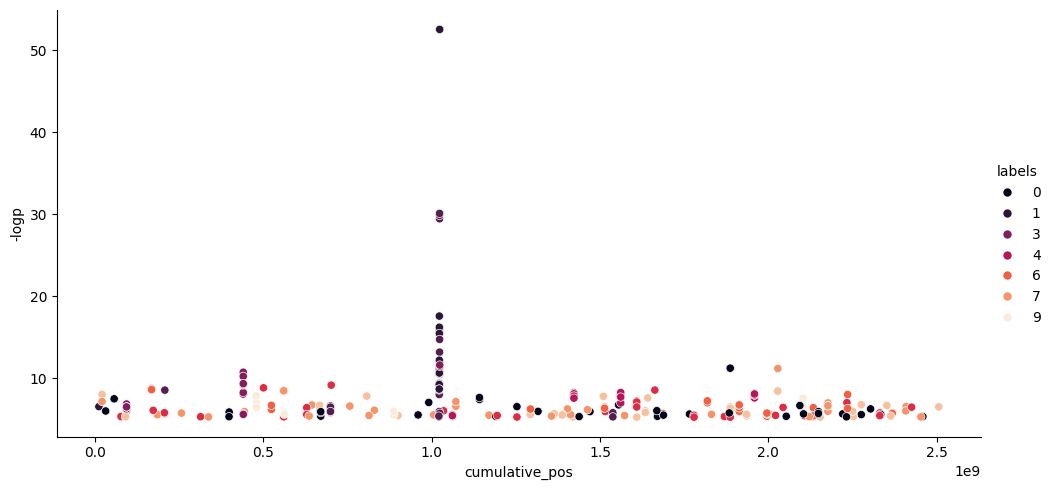

In [102]:
# Plotting
g = sns.relplot(
    data=sumstat_temp,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='labels',
    palette='rocket'
)